# Lending Club Loan Data


In this assignment, you will use real loan data from Lending Club to predict whether a loan will be 'Fully Paid' or 'Charged off'. 

## Table of Contents

* [Import Modules](#Import-Modules)
* [Import Data](#Import-Data)

#### Part 1: 
* [Decision Tree](#Decision-Tree)
* [Evaluate the Decision Trees](#Evaluate-the-Decision-Trees)

#### Part 2: 
* [Pruning the Decision Trees](#Pruning-the-Decision-Trees)
* [Evaluating the Decision Trees](#Evaluating-the-Decision-Trees)
* [Optimal Pruning](#Optimal-Pruning)
* [Weighting and Hyperparameter Grid Search](#Weighting-and-Hyperparameter-Grid-Search)





## Import Modules

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px

# Decision tree: prepare data + estimation
from sklearn.preprocessing import LabelEncoder #to encode categorial variables
from sklearn.model_selection import train_test_split # split data in training and testing sample
from sklearn.tree import DecisionTreeClassifier # decision trees

# Visualization of the decision tree
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

# cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Logistic regression
from sklearn.linear_model import LogisticRegression

## Import Data

The csv-file 'LendingClub_cleaned' contains 'cleaned' loan data for 1.200.349 loans. Each loan has either the status 'Fully Paid' or 'Charged off'. The excel-file 'LCDataDictionary' contains a describtion for each variable.

**Requirements:**

1. The dataset contains 35 variables. However, some of these are not available when making the decision whether to invest in a loan. Check which data items would lead to target leakage.

2. The decision tree algorithm can handle only numerical values. Therefore, encode all categorical  variables with numerical values (this includes dependet variables).

3. Create a dataset that contains all depend variables (X) and one that contains the independent variable (y). Split these datasets in a training and testing part. Hold back 30%  of the total sample as testing data.

In [4]:
df = pd.read_csv(r'LendingClub_cleaned')


The following variables would lead to Target Leakage:
- total_pymnt
- total_pymnt_inv
- total_rec_prncp
- total_rec_int
- total_rec_late_fee
- collection_recovery_fee
- last_pymnt_amnt
- recoveries
Recall that target leakage occurs when a variable that is not a feature is used to predict the target. 

In [5]:
#Gain insights on what type of data each variable includes:
df['emp_length'].describe()

count       1200349
unique           11
top       10+ years
freq         423269
Name: emp_length, dtype: object

In [6]:
df['emp_length'].value_counts()

10+ years    423269
2 years      115047
< 1 year     101490
3 years      101212
1 year        82999
5 years       78780
4 years       75260
6 years       59054
8 years       57990
7 years       56596
9 years       48652
Name: emp_length, dtype: int64

In [7]:
#Encode target labels with value between 0 and n_classes-1.
encode = LabelEncoder()
df['loan_status_n'] = encode.fit_transform(df['loan_status'])
df['initial_list_status_n'] = encode.fit_transform(df['initial_list_status'])
df['application_type_n'] = encode.fit_transform(df['application_type'])
df['earliest_cr_line_n'] = encode.fit_transform(df['earliest_cr_line'])
df['grade_n'] = encode.fit_transform(df['grade'])
df['sub_grade_n'] = encode.fit_transform(df['sub_grade'])
df['term_n'] = encode.fit_transform(df['term'])
df['home_ownership_n'] = encode.fit_transform(df['home_ownership'])
df['verification_status_n'] = encode.fit_transform(df['verification_status'])
df['purpose_n'] = encode.fit_transform(df['purpose'])
df['addr_state_n'] = encode.fit_transform(df['addr_state'])
df['title_n'] = encode.fit_transform(df['title'])
df['emp_length_n'] = encode.fit_transform(df['emp_length'])
df['emp_title_n'] = encode.fit_transform(df['emp_title'])
df.head()

,id,pub_rec,revol_bal,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,open_acc,...,grade_n,sub_grade_n,term_n,home_ownership_n,verification_status_n,purpose_n,addr_state_n,title_n,emp_length_n,emp_title_n
0,68407277,0.0,2765.0,13.0,w,4421.723917,4421.72,3600.0,821.72,7.0,...,2,13,0,1,0,2,38,11442,1,324735
1,68355089,0.0,21470.0,38.0,w,25679.660000,25679.66,24700.0,979.66,22.0,...,2,10,0,1,0,11,41,3155,1,95078
2,68476807,0.0,21929.0,35.0,w,11740.500000,11740.50,10400.0,1340.50,12.0,...,5,25,1,1,1,6,38,20560,3,62151
3,68426831,0.0,8822.0,6.0,w,13708.948530,13708.95,11950.0,1758.95,5.0,...,2,12,0,5,1,2,10,11442,4,292303
4,68476668,0.0,87329.0,27.0,f,21393.800000,21393.80,20000.0,1393.80,12.0,...,1,6,0,1,0,2,23,11442,1,293174


In [8]:
df[['loan_status', 'loan_status_n']].head() #Fully Paid = 1 and Charged Off = 0


,loan_status,loan_status_n
0,Fully Paid,1
1,Fully Paid,1
2,Fully Paid,1
3,Fully Paid,1
4,Fully Paid,1


In [10]:
#Predictors
X = df[[ 'pub_rec', 'revol_bal' , 'total_acc', 'initial_list_status_n', 'open_acc', 
                   'fico_range_high', 'fico_range_low',
                 'application_type_n', 'earliest_cr_line_n', 'grade_n', 'sub_grade_n', 'term_n', 
                  'home_ownership_n', 'annual_inc', 'verification_status_n', 'installment', 'purpose_n', 
                  'addr_state_n', 'loan_amnt','int_rate', 'pub_rec_bankruptcies', 'title_n','emp_length_n', 
        'emp_title_n', 'mort_acc']]

#Outcome
y = df['loan_status_n']

#Train - Test - Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Part 1: 

### Decision Tree 

1. Use the trainings data to derive a decision tree that is fully grown (do not add any parameter options).

In [11]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

2. Create a second decisionm tree that is only grown to depth 5 with DecisionTreeClassifier(max_depth=5). Note: you will learn in the next lecture what this means and why it can be beneficial.

In [12]:
clf2 = DecisionTreeClassifier(max_depth=5)
clf2 = clf2.fit(X_train, y_train)

3. Visualize the decision tree that is only grown to depth 5

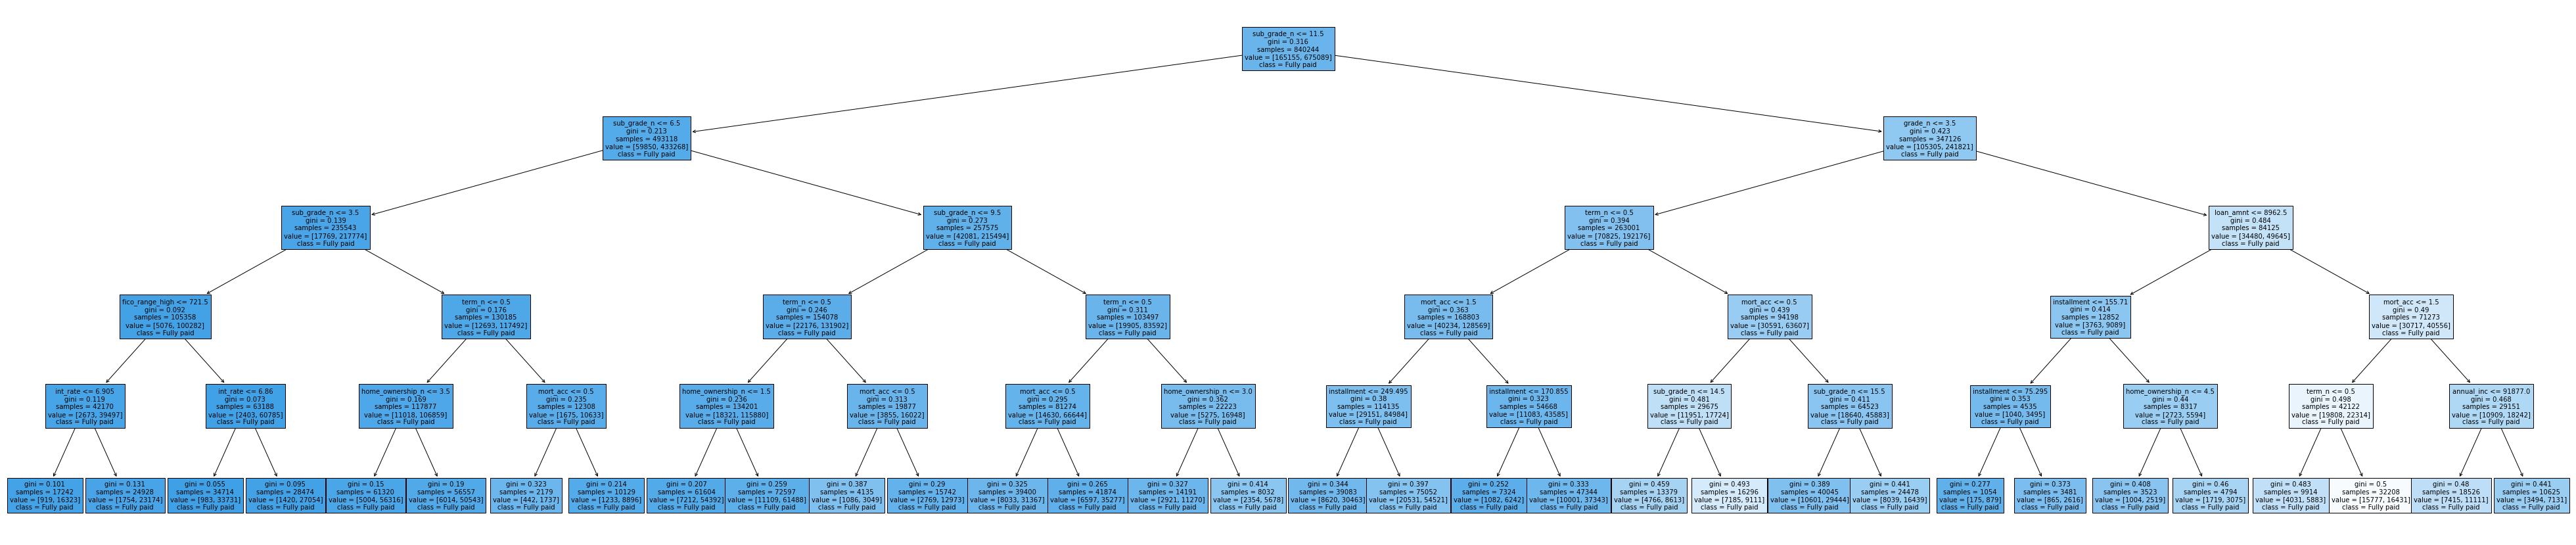

In [13]:
feature_names = X_train.columns
feature_names 

fig = plt.figure(figsize=(70, 15))
_ = plot_tree(clf2,
                 feature_names = feature_names,
                 class_names = {0: 'Charged off', 1: 'Fully paid'},
                 filled = True,
                 fontsize = 10)

#Double click the figure to zoom in

[[Back to TOC]](#Table-of-Contents)

### Evaluate the Decision Trees

4. Calculate for both decision trees metrics that help you to determine their performance.

<AxesSubplot:>

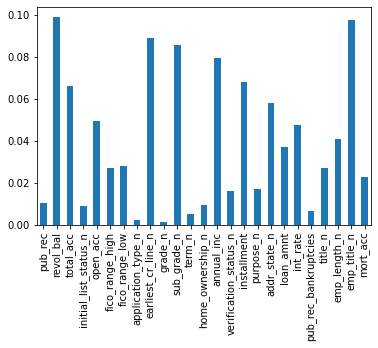

In [15]:
feature_importance = pd.DataFrame(clf.feature_importances_, index = feature_names)
feature_importance.plot(kind = 'bar', legend = None)

5. Which features are mostly responsible for distinguishing loan types in the two decision trees?

<AxesSubplot:>

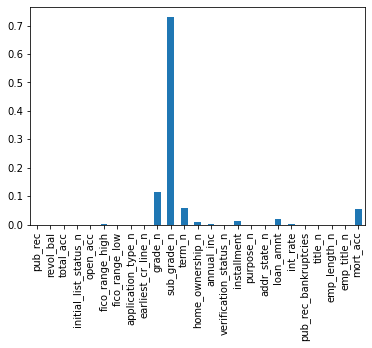

In [16]:
feature_importance2 = pd.DataFrame(clf2.feature_importances_, index = feature_names)
feature_importance2.plot(kind = 'bar', legend = None)

6. Which decision tree is more accurate?

In [28]:
predictions = clf.predict(X_test)
print(f'predictions for fully grown tree: {predictions}')
predictions2 = clf2.predict(X_test)
print(f'predictions for prunned tree: {predictions2}')

predictions for fully grown tree: [1 1 1 ... 1 1 1]
predictions for prunned tree: [1 1 1 ... 1 1 1]


In [19]:
clf2.predict_proba(X_test)

array([[0.1063352 , 0.8936648 ],
       [0.11707032, 0.88292968],
       [0.273557  , 0.726443  ],
       ...,
       [0.4002483 , 0.5997517 ],
       [0.35857322, 0.64142678],
       [0.15754406, 0.84245594]])

In [20]:
print(f'The fully accuracy of the fully grown tree is: {clf.score(X_test, y_test)}')
print(f'The fully accuracy of the pruned tree is: {clf2.score(X_test, y_test)}')

The fully accuracy of the fully grown tree is: 0.7045833854014801
The fully accuracy of the pruned tree is: 0.8040988045153497


In [21]:
#Calculate each metric individually or use the classification_report command to get all of them at once.
report = classification_report(y_test, predictions, target_names=['Charged off', 'Fully Paid'])
print(report)

              precision    recall  f1-score   support

 Charged off       0.27      0.30      0.28     70545
  Fully Paid       0.82      0.80      0.81    289560

    accuracy                           0.70    360105
   macro avg       0.55      0.55      0.55    360105
weighted avg       0.72      0.70      0.71    360105



In [22]:
report2 = classification_report(y_test, predictions2, target_names=['Charged off', 'Fully Paid'])
print(report2)

              precision    recall  f1-score   support

 Charged off       0.00      0.00      0.00     70545
  Fully Paid       0.80      1.00      0.89    289560

    accuracy                           0.80    360105
   macro avg       0.40      0.50      0.45    360105
weighted avg       0.65      0.80      0.72    360105



/Users/angel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/angel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/angel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
cm = confusion_matrix(y_test, predictions) 
print(f'Confusion Matrix fully grown: \n {cm}')
cm2 = confusion_matrix(y_test, predictions2) 
print(f'Confusion Matrix prunned: \n {cm2}')

Confusion Matrix fully grown: 
 [[ 20896  49649]
 [ 56732 232828]]
Confusion Matrix prunned: 
 [[     0  70545]
 [     0 289560]]


7. Which decision tree would you use, when it is more important for you to not classifiy 'Charged off' loans as 'Fully Paid'?

- From above, the prunned decision tree (clf2) is more accurate. However, the recall for 'charged off' is much lower, hence the fully grown decision tree does a better job at identifying all default loans.


## Part 2: 

### Pruning the Decision Trees

In the lecture, you have learned that one way to deal with overfitting is pruning the decision tree. We focused mainly on specifying the maximum depth and cost-complexity-pruning. 

1. Determine the depth of the fully grown decision tree with the command clf.tree_.max_depth


In [29]:
print(clf.tree_.max_depth)

58


2. Determine the depth of the prunned tree decision tree with the command clf.tree_.max_depth



In [30]:
print(clf2.tree_.max_depth)

5


3. Create a decision tree that is pruned by applying cost-complexity pruning with alpha = 0.001. Determine its depth.


In [32]:
clf3 = DecisionTreeClassifier(ccp_alpha = 0.0001)
clf3 = clf3.fit(X_train, y_train)

In [33]:
print(clf3.tree_.max_depth)

6


4. Visualize the pruned trees. How do they differ?

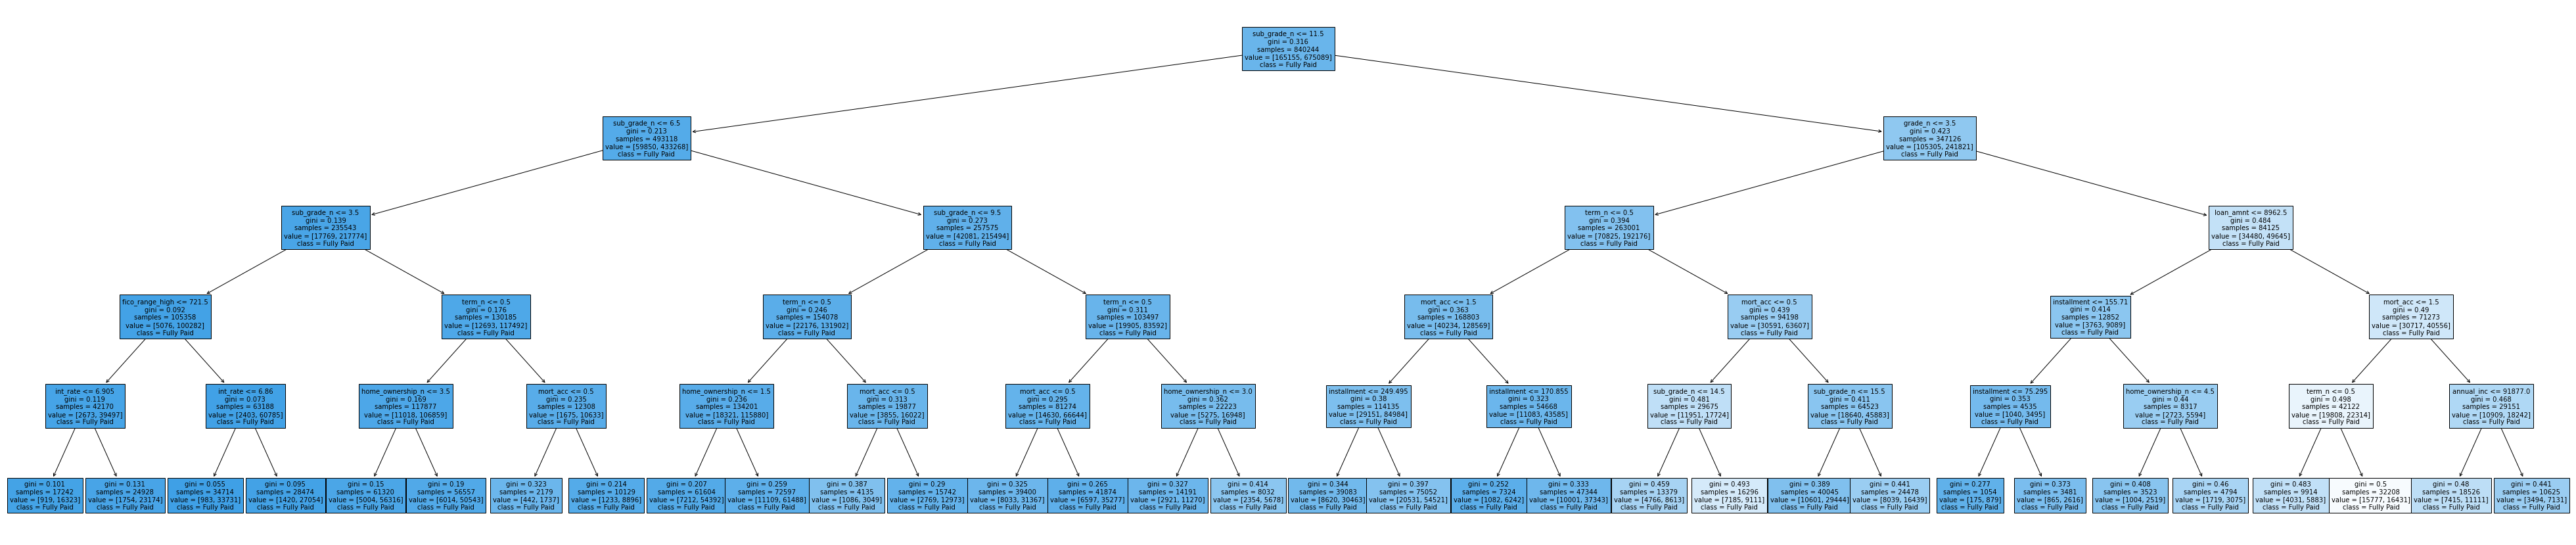

In [34]:
#Prunned 

feature_names = X_train.columns
feature_names

fig = plt.figure(figsize=(70,15))
_ = plot_tree(clf2,
                  feature_names=feature_names,
                  class_names={0:'Charged off', 1:'Fully Paid'},
                  filled=True,
                  fontsize=10)

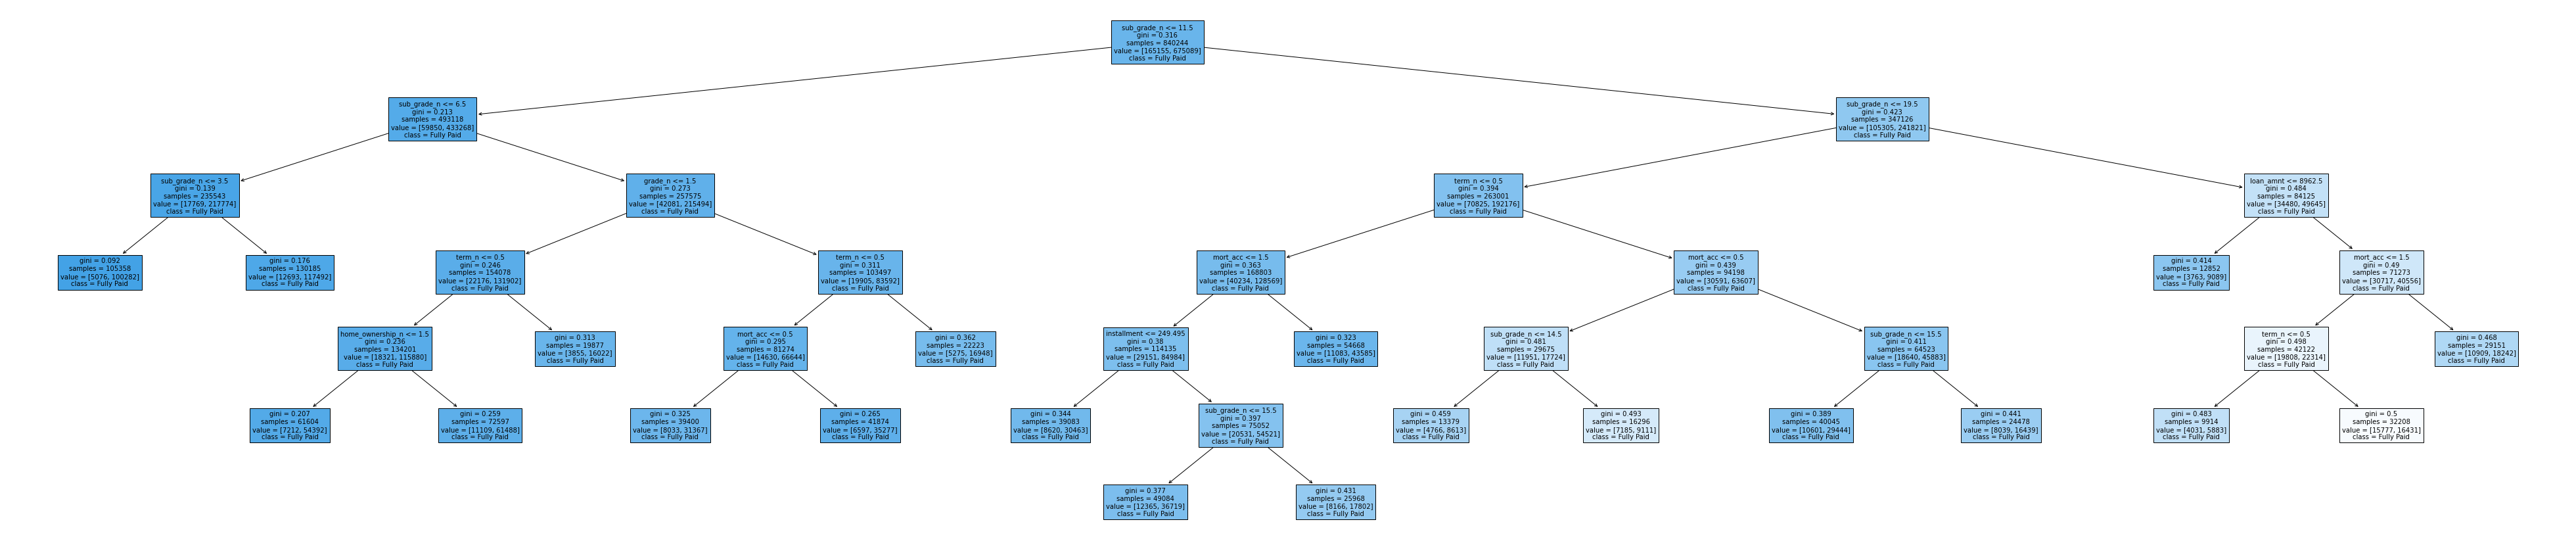

In [35]:
#Prunned by cost complexity

feature_names = X_train.columns
feature_names

fig = plt.figure(figsize=(70,15))
_ = plot_tree(clf3,
                  feature_names=feature_names,
                  class_names={0:'Charged off', 1:'Fully Paid'},
                  filled=True,
                  fontsize=10)

They different in the way that the prunned cost complexity remove the weakest links or irrelavant nodes in the decision tree which decreases the misclassification of predictive outcome, but it may increase complexitity.  


### Evaluating the Decision Trees

Assume there is a huge supply of loans you can invest in. 



5. Create a score metric that returns the expected rate of return from investing only in loans classified by the decision tree as 'fully paid'. Use the average interest rate and the mode of variable term to determine the expected return when the loan is fully paid. Use the difference between the loan amount and the total payments received and divide it by the loan amount to  estimate of the average expected loss if the loan gets charged off.

In [36]:
df['int_rate'].mean()

13.270945208472089

In [37]:
df['term'].value_counts()

 36 months    904833
 60 months    295516
Name: term, dtype: int64

In [38]:
df['percentrecover'] =(df['loan_amnt'] - df['total_pymnt'])/df['loan_amnt']

In [39]:
df2 = df[df['loan_status_n']==0]
df2['percentrecover'].mean()

0.4584737423285672

6. Evaluate the decision trees based on the expected rate of return. 



In [41]:
def ex_return(y_true, y_pred):
    probrepay = precision_score(y_true, y_pred) 
    exret = probrepay*100*0.13*3 + (1-probrepay)*100*(-0.46)
    return exret

print(f'Expected Return for fully grown tree: {ex_return(y_test, clf.predict(X_test))}')
print(f'Expected Return for prunned tree: {ex_return(y_test, clf2.predict(X_test))}')
print(f'Expected Return for prunned by cost complexity: {ex_return(y_test, clf3.predict(X_test))}')

Expected Return for fully grown tree: 24.060146489802708
Expected Return for prunned tree: 22.34839838380472
Expected Return for prunned by cost complexity: 22.34839838380472


7. What would be the expected rate of return in case of randomly investing in loans? What would be so far the best investment strategy?

In [42]:
probinitial = df['loan_status_n'].mean()
print(probinitial*100*0.13*3 + (1-probinitial)*100*(-0.46))

22.30943750525889


### Optimal Pruning

Note that the data set is huge, so the code might need quite some time to run. Therefore, we proceed with a smaller sample. However, if you have a lot of time, feel free to proceed with the whole sample.

In [43]:
X_trash, X_small, y_trash, y_small = train_test_split(X, y, test_size=0.01)

In [44]:
#check whether the smaller sample is similar with respect to the percentage of charged off loans
df['loan_status_n'].mean() 

0.8036404412383399

In [45]:
y_small.mean()

0.8000666444518494

In [46]:
len(y_small)

12004

In [47]:
my_score = make_scorer(ex_return) 

8. When using cost-complexity pruning, which of the following alphas would lead to the highest expected rate of return: ( 0.00001, 0.0001,0.0002,0.0005,0.0008,0.001, 0.01, 0.1)?


In [51]:
c_scores = []

for c in (0.00001, 0.0001, 0.0002, 0.0005, 0.0008, 0.001, 0.01, 0.1):
    scores = cross_val_score(
        DecisionTreeClassifier(ccp_alpha=c), X_small, y_small, cv=10, scoring=my_score)
    c_scores.append(scores.mean())
    
print(f'Expected Return with corressponding ccp: \n {c_scores}')

Expected Return with corressponding ccp: 
 [23.54342871190853, 23.761160801073096, 23.91340133411945, 22.501376496231927, 22.149275493093462, 22.005661948376353, 22.005661948376353, 22.005661948376353]


9. Which of the following maximal depths would lead to the highest expected return: (None, 5, 10, 20, 30, 40, 50 )?

In [52]:
d_scores = []

for d in (None, 5, 10 , 20, 30, 40, 50 ):
    scores = cross_val_score(
        DecisionTreeClassifier(max_depth=d), X_small, y_small, cv=10, scoring=my_score)
    d_scores.append(scores.mean())
    
print(f'Expected Return for corresponding max depth: \n {d_scores}')

Expected Return for corresponding max depth: 
 [23.793938819433723, 22.893431569398306, 23.67671268028858, 23.771760936874756, 23.68970219467245, 23.703323785798155, 23.647783304852332]


### Weighting and Hyperparameter Grid Search
Not misclassifying loans that will be charged off is more important since investing in a charged off loan is connected with losing on average 45 % of the invested amount. 

10. Create a decision tree with the parameters ccp_alpha=0.0009 and class_weight={0:3,1:1}. Visualize this tree. How does it differ from the ones before?

In [56]:
clf4 = DecisionTreeClassifier(ccp_alpha=0.0009, class_weight={0:3, 1:1})
clf4 = clf4.fit(X_small, y_small)

In [57]:
print(clf4.tree_.max_depth)

4


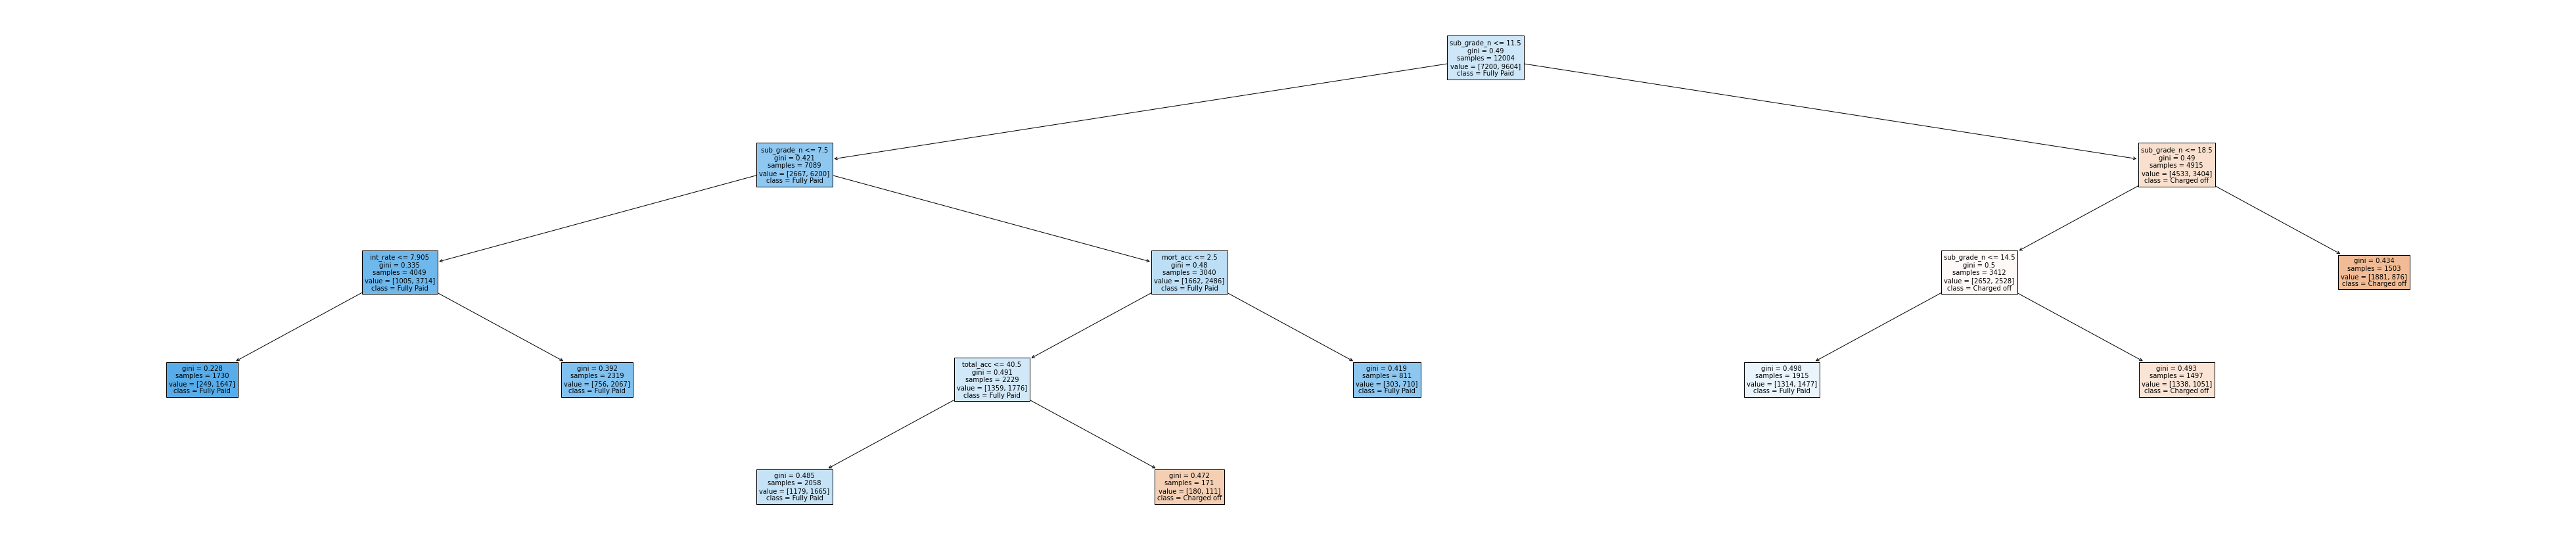

In [58]:
feature_names = X_train.columns
feature_names

fig = plt.figure(figsize=(70,15))
_ = plot_tree(clf4,
                  feature_names=feature_names,
                  class_names={0:'Charged off', 1:'Fully Paid'},
                  filled=True,
                  fontsize=10)


11. Search for the best hyperparameter combination from the follwing set: parameters = {'max_depth': [4,5,7,10,15,20,30,40], 'class_weight':[{0:1,1:1}, {0:2,1:1},{0:5,1:1},{0:10,1:1},{0:20,1:1}]}

In [60]:
parameters = {'max_depth': [4,5,7,10,15,20,30,40], 'class_weight':[{0:1,1:1}, {0:2,1:1},{0:5,1:1},{0:10,1:1},{0:20,1:1}]}

grid_search_cv = GridSearchCV(DecisionTreeClassifier( ), parameters, verbose=1, cv=10, scoring = my_score)

grid_search_cv.fit(X_small, y_small)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1},
                                          {0: 5, 1: 1}, {0: 10, 1: 1},
                                          {0: 20, 1: 1}],
                         'max_depth': [4, 5, 7, 10, 15, 20, 30, 40]},
             scoring=make_scorer(ex_return), verbose=1)

12. Feel free to change the search Grid. Are you able to find a better parameter combination?

In [61]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight={0: 20, 1: 1}, max_depth=4)

In [62]:
cross_val_score(DecisionTreeClassifier(max_depth=4, class_weight={0:10,1:1}), X_small, y_small, cv=10, scoring=my_score).mean()

33.05732974308853

In [63]:
cross_val_score(DecisionTreeClassifier(max_depth=4, class_weight={0:10,1:1}), X, y, cv=10, scoring=my_score).mean()

34.0909281026008

13. Which decision tree yields the highest expected return? Does it pay off to use decision trees to identify loan to invest in? Visualize the final decision tree.

In [64]:
clf_final = DecisionTreeClassifier(max_depth=4, class_weight={0:10,1:1})
clf_final = clf_final.fit(X_small, y_small)

In [ ]:
feature_names = X_train.columns
feature_names

fig = plt.figure(figsize=(30,15))
_ = plot_tree(clf_final,
                  feature_names=feature_names,
                  class_names={0:'Charged off', 1:'Fully Paid'},
                  filled=True,
                  fontsize=10)